In [1]:
import gymnasium as gym
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

env_id = "BipedalWalker-v3"
env = gym.make(env_id)

/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:


models = {
    "A2C": A2C("MlpPolicy", env, verbose=0),
    "PPO": PPO("MlpPolicy", env, verbose=0),
    "SAC": SAC("MlpPolicy", env, verbose=0)
}

rewards = {}
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.learn(total_timesteps=300_000)
    mean_r, std_r = evaluate_policy(model, env, n_eval_episodes=10, render=False)
    rewards[name] = (mean_r, std_r)
    print(f"{name}: Reward media={mean_r:.2f} ± {std_r:.2f}")



/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should b


Entrenando A2C...


/home/agustin/Desktop/CEIA UBA/Aprendizaje por Refuerzo II/CEIA-AprendizajeRefuerzoII/.venv/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


A2C: Reward media=-109.48 ± 11.47

Entrenando PPO...
PPO: Reward media=251.66 ± 62.75

Entrenando SAC...
SAC: Reward media=276.45 ± 2.46


In [3]:
from stable_baselines3.common.logger import configure

for name, model in models.items():
    model.set_logger(configure(f"./logs/{name}", ["stdout", "csv", "tensorboard"]))
    model.learn(total_timesteps=300_000)


Logging to ./logs/A2C


------------------------------------
| time/                 |          |
|    fps                | 853      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.5     |
|    explained_variance | -0.00781 |
|    learning_rate      | 0.0007   |
|    n_updates          | 60099    |
|    policy_loss        | -0.0924  |
|    std                | 0.481    |
|    value_loss         | 0.0024   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 718      |
|    ep_rew_mean        | -125     |
| time/                 |          |
|    fps                | 859      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -2.51    |
|    explained_variance | -16.8    |
|

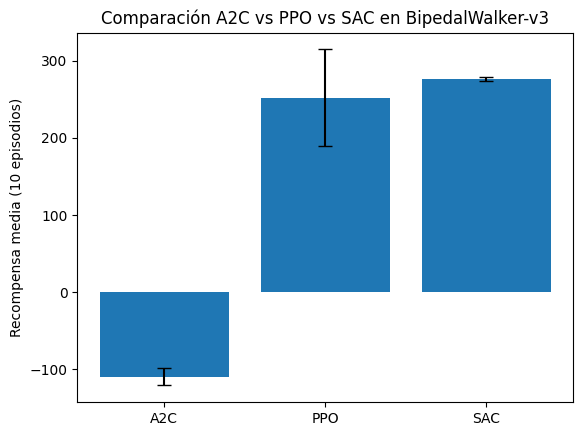

In [4]:
algos = list(rewards.keys())
means = [rewards[a][0] for a in algos]
stds  = [rewards[a][1] for a in algos]

plt.bar(algos, means, yerr=stds, capsize=5)
plt.ylabel("Recompensa media (10 episodios)")
plt.title("Comparación A2C vs PPO vs SAC en BipedalWalker-v3")
plt.show()
